In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

from irc.manager import IRCManager

# Train a rational agent

We first train a rational agent for a given foraging environment. The environment can be specified by a dictionary object or a yaml file.

The example environment is a `boxforage.env.IdenticalBoxesEnv` instance, whose parameters are the following:
- $p_\mathrm{appear} \in [0, 1]$: food appear probability.
- $p_\mathrm{vanish} \in [0, 1]$: food vanish probability.
- $p_\mathrm{cue} \in [0, 1]$: color cue parameter. The closer $p_\mathrm{cue}$ is to 0 or 1, the higher discriminability will be.
- $\lambda_\mathrm{center} \in (0, 1)$: vintage point parameter. Greater value means higher discriminability of color cues when viewed at the room center.
- $r_\mathrm{food} \in [0, \infty)$: reward of food.
- $r_\mathrm{move} \in (-\infty, 0]$: reward of moving per unit distance.

The agent we train assumes an environment with parameter $(0.2, 0.05, 0.8, 0.1, 10, -1)$, and updates its belief with respect to the internal environment.

In [2]:
manager = IRCManager(
    agent_defaults='irc_defaults/identical_boxes.yaml',
)
env_param = (0.2, 0.05, 0.8, 0.1, 10., -1.)
num_epochs = 30
agent = manager.train_agent(env_param=env_param, num_epochs=num_epochs)

Checkpoint (epoch 30) loaded.


The snippet above can also be run from command line via `train-one-agent.py`.

In [3]:
!python train-one-agent.py env_param=[0.2,0.05,0.8,0.1,10,-1] num_epochs=30

Checkpoint (epoch 30) loaded.


# Inspect training progress

We can check the RL training progress of an agent, and assess whether it has reached equilibrium.

Fetching the most trained agent so far (epoch 30).


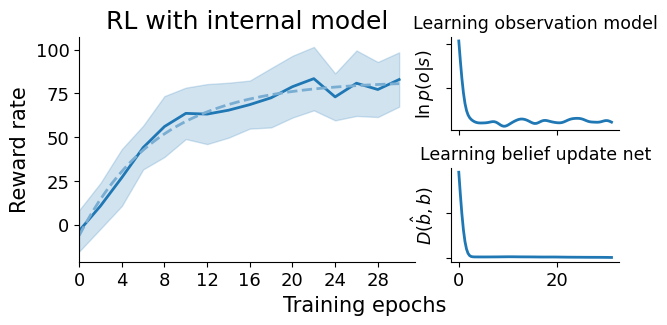

In [4]:
env_param = (0.2, 0.05, 0.8, 0.1, 10., -1.)
agent, fig = manager.inspect_agent(env_param)